In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = 'review-details.csv'
df = pd.read_csv(file_path)

# Display basic information about the dataset
print(df.info())

# Show the first few rows
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Display summary statistics
print(df.describe())

# Print unique values in 'is_competitor' column
print("Unique values in 'is_competitor' column:", df['is_competitor'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2501 entries, 0 to 2500
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   report_date             2501 non-null   object 
 1   online_store            2501 non-null   object 
 2   upc                     2501 non-null   int64  
 3   retailer_product_code   2501 non-null   object 
 4   brand                   2501 non-null   object 
 5   category                2501 non-null   object 
 6   sub_category            2501 non-null   object 
 7   product_description     2501 non-null   object 
 8   review_date             2501 non-null   object 
 9   review_rating           2501 non-null   int64  
 10  review_title            2396 non-null   object 
 11  review_text             2501 non-null   object 
 12  is_competitor           2501 non-null   int64  
 13  manufacturer            2501 non-null   object 
 14  market                  2501 non-null   

In [2]:
!pip install textblob
from textblob import download_corpora




[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


100%|████████████████████████████████████████████████████████████████████████████| 2501/2501 [00:02<00:00, 1018.49it/s]


       review_rating  review_length    sentiment  rating_sentiment_diff  \
count    2501.000000    2501.000000  2501.000000            2501.000000   
mean        4.456218     162.582167     0.330097               1.388140   
std         1.108595     184.484597     0.299412               0.741473   
min         1.000000       2.000000    -1.000000               0.000000   
25%         4.000000      36.000000     0.106574               0.750000   
50%         5.000000      97.000000     0.309000               1.392708   
75%         5.000000     249.000000     0.504048               1.912500   
max         5.000000    1624.000000     1.000000               3.750000   

           anomaly  
count  2501.000000  
mean      0.900040  
std       0.435894  
min      -1.000000  
25%       1.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  


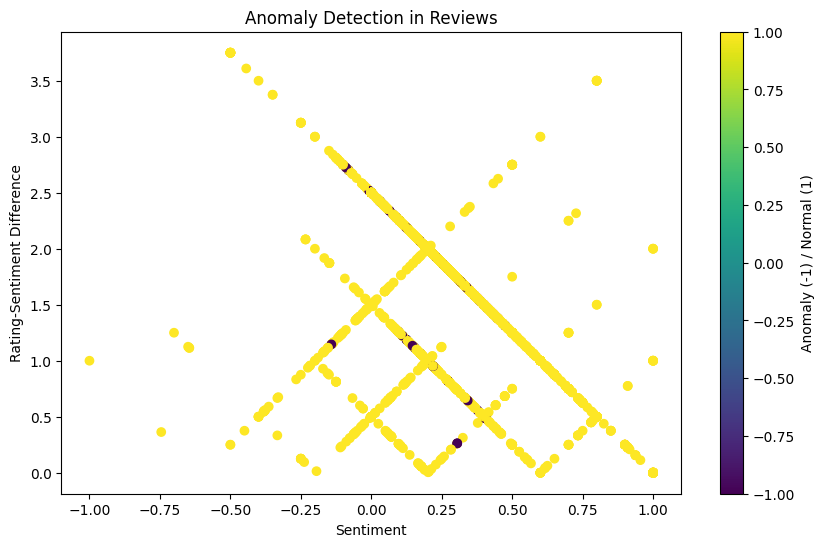

Percentage of potential fake reviews: 4.998000799680128
      review_rating  sentiment  rating_sentiment_diff  \
229               5  -0.100974               2.752435   
1981              5  -0.089744               2.724359   
1245              5  -0.080952               2.702381   
1263              5  -0.080952               2.702381   
1348              5  -0.006771               2.516927   

                                            review_text  
229   Got this to try and wasnt disappointed. Its a ...  
1981  My daughter recommended this to me as she has ...  
1245  Always apprehensive when buying wipes as I bre...  
1263  Always apprehensive when buying wipes as I bre...  
1348  I usually like a moisturising face wash as I h...  


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from textblob import TextBlob
from tqdm import tqdm


# Feature engineering
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

tqdm.pandas()
df['review_length'] = df['review_text'].str.len()
df['sentiment'] = df['review_text'].progress_apply(get_sentiment)
df['rating_sentiment_diff'] = abs(df['review_rating'] - ((df['sentiment'] + 1) * 2.5))

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['review_text'].fillna(''))

# Combine features
features = np.hstack((tfidf_matrix.toarray(),
                      df[['review_length', 'sentiment', 'rating_sentiment_diff']].values))

# Anomaly detection
clf = IsolationForest(contamination=0.05, random_state=42)
df['anomaly'] = clf.fit_predict(features)

# Display results
print(df[['review_rating', 'review_length', 'sentiment', 'rating_sentiment_diff', 'anomaly']].describe())

# Plot anomalies
plt.figure(figsize=(10, 6))
plt.scatter(df['sentiment'], df['rating_sentiment_diff'], c=df['anomaly'], cmap='viridis')
plt.colorbar(label='Anomaly (-1) / Normal (1)')
plt.xlabel('Sentiment')
plt.ylabel('Rating-Sentiment Difference')
plt.title('Anomaly Detection in Reviews')
plt.show()
plt.savefig('anomaly_detection_plot.png')
plt.close()

print("Percentage of potential fake reviews:", (df['anomaly'] == -1).mean() * 100)

# Display top 5 potential fake reviews
potential_fake_reviews = df[df['anomaly'] == -1].sort_values('rating_sentiment_diff', ascending=False)
print(potential_fake_reviews[['review_rating', 'sentiment', 'rating_sentiment_diff', 'review_text']].head())